<a href="https://colab.research.google.com/github/yangxuan8/CMI-EVSI/blob/main/sample_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive')

Mounted at /content/drive


# Standard Imports

In [ ]:
!pip install pytorch_lightning
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dynamic_selection as ds
import tensorflow as tf
import pickle
from torch.utils.data import DataLoader,Subset, TensorDataset
from torchmetrics import Accuracy, AUROC
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection,BaseModel
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## Parameters

In [ ]:
tf.test.is_gpu_available()

True

In [ ]:
# EVSI rank: xmv_10, xmeas_33, xmv_4, xmeas_25, xmeas_21, xmeas_35
sensors = ['<EngSpd>',
 'FuelFlw',
 '<EngTrq>',
 '<ThrPosPct>',
 '<Acc>',
 'VelocityRef:1',
 '<BattSoc>',
 '<xdot>',
 '<WgAreaPct>',
 '<BattPwr>']
model_path = '/content/drive/MyDrive/models/' + '0_' + 'none' + '/'

# Original Dataset

In [ ]:
train1 = pd.read_csv("/content/drive/MyDrive/Dataset_RP/traincsv.csv")
train2 = pd.read_csv("/content/drive/MyDrive/Dataset_RP/train12csv.csv")
train1['simulationRun'] = 1
train2['simulationRun'] = 2

train = pd.concat([train1,train2])
test = pd.read_csv("/content/drive/MyDrive/Dataset_RP/HEVP2_US06_test.csv")


## Data Loading

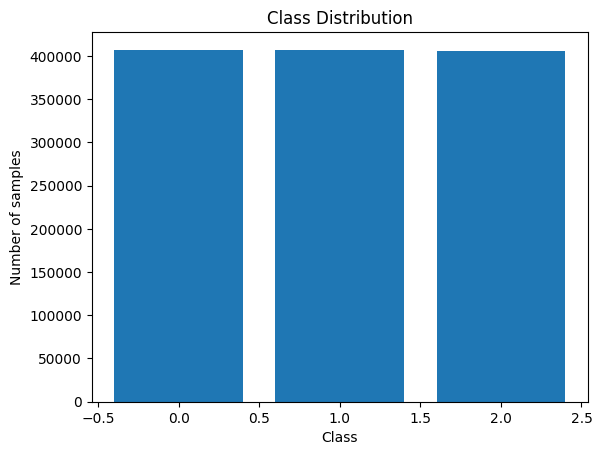

In [ ]:
class_distribution = train['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for i in range (3):
  for j in range (1,3):
    Sample_temp = train[train['faultNumber']==i]
    Sample_temp = Sample_temp[Sample_temp['simulationRun']==j]
    begin = 0
    train_size = int(((len(Sample_temp)) * 0.6)/20)
    val_size = int(((len(Sample_temp) * 0.2)/20))
    test_size = int(((len(Sample_temp) * 0.2)/20))

    for k in range (1,21):
      train_data =pd.concat([train_data,Sample_temp[begin:begin+train_size]])
      val_data = pd.concat([val_data,Sample_temp[begin+train_size:begin+train_size+val_size]])
      test_data = pd.concat([test_data,Sample_temp[begin+train_size+val_size:begin+train_size+val_size+test_size]])
      begin = begin+train_size+val_size+test_size
Sampled_train = train_data
Sampled_cv = val_data
Sampled_test = test_data

In [ ]:
class_distribution = Sampled_train['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

class_distribution = Sampled_cv['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

class_distribution = Sampled_test['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

Sampled_train.to_csv("/content/drive/MyDrive/dataset/outputtrain.csv", index=True)
Sampled_cv.to_csv("/content/drive/MyDrive/dataset/outputcv.csv", index=True)
Sampled_test.to_csv("/content/drive/MyDrive/dataset/outputtest.csv", index=True)

# Sampling

In [ ]:
Sampled_train = pd.DataFrame() # dataframe to store the train dataset
Sampled_test = pd.DataFrame() # dataframe to store test
Sampled_cv = pd.DataFrame() # dataframe to store cv data
# Program to construct the sample train data
frame = []
for i in set(train['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = train[train['faultNumber'] == i][0:20000]
        frame.append(b_i)
    else:
        fr = []
        b_x = train[train['faultNumber'] == i][0:12000]
        fr.append(b_x)
        b_i = pd.concat(fr)
    frame.append(b_i)
Sampled_train = pd.concat(frame)

# Program to construct the sample CV Data
frame = []
for i in set(train['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = train[train['faultNumber'] == i][20000:30000]
        frame.append(b_i)
    else:
        fr = []
        b = train[train['faultNumber'] == i][12000:17000]
        fr.append(b_x)
        b_i = pd.concat(fr)
    frame.append(b_i)
Sampled_cv = pd.concat(frame)

# Program to construct Sampled Test data
frame = []
for i in set(test['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = train[train['faultNumber'] == i][30000:32000]
        frame.append(b_i)
    else:
        fr = []
        b = train[train['faultNumber'] == i][18600:23600]
        fr.append(b_x)
        b_i = pd.concat(fr)
    frame.append(b_i)
Sampled_test = pd.concat(frame)

In [ ]:
Sampled_train.to_csv('/content/drive/MyDrive/dataset1/train.csv', index = False)
Sampled_test.to_csv("/content/drive/MyDrive/dataset1/test.csv", index = False)
Sampled_cv.to_csv("/content/drive/MyDrive/dataset1/cv.csv", index = False)

# Loading From CSV

In [ ]:
Sampled_train= pd.read_csv('/content/drive/MyDrive/dataset1/train.csv')
Sampled_test = pd.read_csv("/content/drive/MyDrive/dataset1/test.csv")
Sampled_cv = pd.read_csv("/content/drive/MyDrive/dataset1/cv.csv")

In [ ]:
dataset = pd.concat([Sampled_train,Sampled_test])
dataset = pd.concat([dataset,Sampled_cv])
dataset.to_csv('/content/drive/MyDrive/dataset1/dataset.csv', index = False)

## Training on the Whole data Set (only run this if you are gonna train on the whole dataset)

In [ ]:
Sampled_train, Sampled_cv = train_test_split(train, test_size = 0.2, shuffle = False)
Sampled_test = test

In [ ]:
test

,faultNumber,VelocityRef:1,<xdot>,<BattSoc>,<BattPwr>,<Cltch1State>,<Cltch2State>,<BattV>,<TransGear>,<EngSpd>,...,<MotTrq>,<StartTrq>,StartCmd,MotTrqCmd,BattCrnt:1,MotPwrElec:1,MotPwrMech:1,IntkVlvLiftCmd,FuelMainSoi,FuelFlw
0,2,0.000000,0.000000e+00,60.0,0.000000e+00,False,True,272.952000,1,0.000000e+00,...,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0.000000,0.000000,0,0,0.000000
1,2,0.000000,-3.098370e-94,60.0,1.871770e-32,True,True,272.952000,1,-9.380630e-45,...,0.000000,-8.103270e-37,0,0.000000,6.857520e-35,0.000000,0.000000,0,0,0.000000
2,2,0.000000,-3.098370e-94,60.0,6.295040e-12,True,True,272.952000,1,-2.545620e-24,...,0.000000,-2.308160e-16,0,0.000000,2.306280e-14,0.000000,0.000000,0,0,0.000000
3,2,0.000000,-3.098370e-94,60.0,6.295040e-12,False,True,272.952000,1,-2.545620e-24,...,0.000000,-2.308160e-16,0,0.000000,2.306280e-14,0.000000,0.000000,0,0,0.000000
4,2,0.000000,-3.098370e-94,60.0,1.706150e-06,False,True,272.952000,1,-4.008180e-22,...,0.000000,1.030290e-13,0,0.000000,6.250720e-09,0.000000,0.000000,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203015,2,31.607438,1.161429e+01,0.0,3.032153e+00,True,False,201.599326,1,4.741443e+03,...,0.005147,0.000000e+00,0,0.004399,1.504049e-02,2.822574,2.555255,0,0,0.000712
203016,2,31.606991,1.161375e+01,0.0,2.957100e+00,True,False,201.599342,1,4.741221e+03,...,0.005019,0.000000e+00,0,0.004292,1.466820e-02,2.752714,2.492007,0,0,0.000712
203017,2,31.606544,1.161321e+01,0.0,2.883914e+00,True,False,201.599359,1,4.740999e+03,...,0.004895,0.000000e+00,0,0.004184,1.430517e-02,2.684581,2.430331,0,0,0.000712
203018,2,31.606096,1.161266e+01,0.0,2.812530e+00,True,False,201.599375,1,4.740777e+03,...,0.004774,0.000000e+00,0,0.004082,1.395109e-02,2.618136,2.370176,0,0,0.000712


# Preprocessing

In [ ]:
# make the Y value usable in LSTM
y_train = to_categorical(Sampled_train['faultNumber'],num_classes=3)
y_test = to_categorical(Sampled_test['faultNumber'],num_classes=3)
y_cv = to_categorical(Sampled_cv['faultNumber'],num_classes=3)

In [ ]:
x_train_df = Sampled_train.drop(['faultNumber','simulationRun'],axis=1)
x_test_df = Sampled_test.drop(['faultNumber','simulationRun'],axis =1)
x_cv_df = Sampled_cv.drop(['faultNumber','simulationRun'],axis =1)

In [ ]:
def feature_remover(features_names):
    # remove a list of features from x

    dimension = dict()

    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)

    # create a copy so we don't change the original dataframe
    x_train_masked_df = x_train_df.copy()
    x_test_masked_df = x_test_df.copy()
    x_cv_masked_df = x_cv_df.copy()

    for feature in features_names:
        x_train_masked_df.drop([feature], axis = 1, inplace = True)
        x_test_masked_df.drop([feature], axis = 1, inplace = True)
        x_cv_masked_df.drop([feature], axis = 1, inplace = True)

    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]

    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)

    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))

    return dimension, x_train, x_test, x_cv

In [ ]:
def x_generator(masked, feature_name):
    # generate the needed x matrix for training, while keeping x_df intact

    dimension = dict()

    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)

    # decide whether to mask a feature or not
    if masked == True:
        x_train_masked_df = x_train_df.drop([feature_name], axis = 1)
        x_test_masked_df = x_test_df.drop([feature_name], axis = 1)
        x_cv_masked_df = x_cv_df.drop([feature_name], axis = 1)
    else:
        x_train_masked_df = x_train_df.copy()
        x_test_masked_df = x_test_df.copy()
        x_cv_masked_df = x_cv_df.copy()

    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]

    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)

    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))

    return dimension, x_train, x_test, x_cv

# Models Training

In [ ]:
def train_model(x_train, y_train, x_cv, y_cv, train_col, feature_name):
    model = Sequential()
    model.add(LSTM(256,input_shape= (train_col, 1),return_sequences= True))
    model.add(LSTM(128,return_sequences= False))
    model.add(Dense(300))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    # training
    model.fit(x_train, y_train, epochs=15,verbose=1,batch_size=256,validation_data = (x_cv, y_cv))

    # saving the model
    model.save(model_path + feature_name)

    # saving the history
    model_paras = model.history
    with open(model_path + feature_name + '/history.pickle', 'wb') as handle:
        pickle.dump(model_paras.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [ ]:
def visulize_model(history, feature_name):
    x = list(range(1,len(history['loss']) + 1))
    plt.figure(figsize=(5,5))
    plt.plot(x, history['val_accuracy'],color = 'r',label = 'Validation Accuracy')
    plt.plot(x, history['accuracy'],color = 'b',label = 'Training Accuracy')
    plt.grid()
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.savefig(model_path + feature_name + '/performance.png')
    plt.show()

## Base Model

In [ ]:
dimension, x_train, x_test, x_cv = feature_remover(features_names = sensors)
print(dimension['train_col'])

complete_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], 'base')

22
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 22, 256)           264192    
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_9 (Dense)             (None, 300)               38700     
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               38528     
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538927 (2.06 MB)
Trainable params: 53

### +1 Model

In [ ]:
for sensor in sensors:
    remove_sensors = sensors.copy()
    remove_sensors.remove(sensor)
    dimension, x_train, x_test, x_cv = feature_remover(features_names = remove_sensors)

    print(dimension['train_col'])

    complete_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], '+' + sensor)

23
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 23, 256)           264192    
                                                                 
 lstm_9 (LSTM)               (None, 128)               197120    
                                                                 
 dense_12 (Dense)            (None, 300)               38700     
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               38528     
                                                                 
 dense_14 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538927 (2.06 MB)
Trainable params: 53

## Preprocessing for LSTM

In [ ]:
print(len(x_train_df), len(x_test_df), len(x_cv_df))
train_row = len(x_train_df)
test_row = len(x_test_df)
cv_row = len(x_cv_df)

64000 12000 44000


In [ ]:
print(x_train_df.shape[1], x_test_df.shape[1], x_cv_df.shape[1])
train_col = x_train_df.shape[1]
test_col = x_test_df.shape[1]
cv_col = x_cv_df.shape[1]

32 32 32


In [ ]:
x_train = np.resize(x_train_df,(train_row, train_col, 1))
x_test = np.resize(x_test_df,(test_row, test_col, 1))
x_cv = np.resize(x_cv_df,(cv_row, cv_col, 1))

In [ ]:
x_train_df

,VelocityRef:1,<xdot>,<BattSoc>,<BattPwr>,<Cltch1State>,<Cltch2State>,<BattV>,<TransGear>,<EngSpd>,<IntkVlvLift>,...,<MotTrq>,<StartTrq>,StartCmd,MotTrqCmd,BattCrnt:1,MotPwrElec:1,MotPwrMech:1,IntkVlvLiftCmd,FuelMainSoi,FuelFlw
0,0.000000,0.000000e+00,60.000000,0.000000e+00,0,1,272.952000,1,0.000000e+00,0,...,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0.000000,0.000000,0,0,0.00000
1,0.000000,-3.100000e-94,60.000000,1.870000e-32,1,1,272.952000,1,-9.380000e-45,0,...,0.000000,-8.100000e-37,0,0.000000,6.860000e-35,0.000000,0.000000,0,0,0.00000
2,0.000000,-3.100000e-94,60.000000,6.300000e-12,1,1,272.952000,1,-2.550000e-24,0,...,0.000000,-2.310000e-16,0,0.000000,2.310000e-14,0.000000,0.000000,0,0,0.00000
3,0.000000,-3.100000e-94,60.000000,6.300000e-12,0,1,272.952000,1,-2.550000e-24,0,...,0.000000,-2.310000e-16,0,0.000000,2.310000e-14,0.000000,0.000000,0,0,0.00000
4,0.000000,-3.100000e-94,60.000000,1.710000e-06,0,1,272.952000,1,-4.010000e-22,0,...,0.000000,1.030000e-13,0,0.000000,6.250000e-09,0.000000,0.000000,0,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,9.434779,8.062188e+00,58.645464,7.552916e+03,1,1,270.281790,3,1.413191e+03,0,...,42.998121,-3.830000e-80,0,44.763696,2.794460e+01,7510.122266,6364.804710,0,0,0.00023
63996,9.438803,8.063994e+00,58.644729,7.607488e+03,1,1,270.268994,3,1.413540e+03,0,...,43.299359,-3.270000e-80,0,45.025771,2.814784e+01,7561.044294,6410.988805,0,0,0.00023
63997,9.442826,8.065814e+00,58.643989,7.660800e+03,1,1,270.256474,3,1.413891e+03,0,...,43.593111,-6.020000e-80,0,45.275057,2.834641e+01,7610.852645,6456.097342,0,0,0.00023
63998,9.446849,8.067648e+00,58.643243,7.712888e+03,1,1,270.244236,3,1.414244e+03,0,...,43.879654,-4.950000e-80,0,45.524343,2.854043e+01,7659.559573,6500.167463,0,0,0.00023


## Preprocessing for LSTM_Masked

In [ ]:
print(len(x_train_df), len(x_test_df), len(x_cv_df))
train_row = len(x_train_df)
test_row = len(x_test_df)
cv_row = len(x_cv_df)

64000 12000 44000


In [ ]:
# Hide one feature
x_train_masked_df = x_train_df.drop(['StartCmd'], axis = 1)
x_test_masked_df = x_test_df.drop(['StartCmd'], axis = 1)
x_cv_masked_df = x_cv_df.drop(['StartCmd'], axis = 1)

In [ ]:
print(x_train_masked_df.shape[1], x_test_masked_df.shape[1], x_cv_masked_df.shape[1])
train_col = x_train_masked_df.shape[1]
test_col = x_test_masked_df.shape[1]
cv_col = x_cv_masked_df.shape[1]

31 31 31


In [ ]:
x_train = np.resize(x_train_masked_df, (train_row, train_col, 1))
x_test = np.resize(x_test_masked_df, (test_row, test_col, 1))
x_cv = np.resize(x_cv_masked_df, (cv_row, cv_col, 1))

# LSTM

In [ ]:
model = Sequential()
model.add(LSTM(256,input_shape= (train_col,1),return_sequences= True))
model.add(LSTM(128,return_sequences= False))
model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

NameError: name 'train_col' is not defined

In [ ]:
model.fit(x_train, y_train, epochs=110,verbose=2,batch_size=256,validation_data = (x_cv, y_cv))

NameError: name 'model' is not defined